# EDA

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('merged_file.csv')

In [3]:
df.head()

,Student ID,Age,Gender,Height,Weight,Blood Type,BMI,Temperature,Heart Rate,Blood Pressure,Cholesterol,Diabetes,Smoking
0,1.0,18.0,Female,161.777924,72.354947,O,27.645835,98.614398,95.0,109.0,203.0,No,Yes
1,2.0,34.0,Male,152.069157,47.630941,B,20.597139,98.714977,93.0,104.0,163.0,No,No
2,3.0,32.0,Female,182.537664,55.741083,A,16.729017,98.260293,76.0,130.0,216.0,Yes,No
3,4.0,30.0,Male,182.112867,63.332207,B,19.096042,98.839605,99.0,112.0,141.0,No,Yes
4,5.0,23.0,Female,179.339293,46.234173,O,14.375143,98.480008,95.0,139.0,231.0,No,No


In [4]:
df.describe()

,Student ID,Age,Height,Weight,BMI,Temperature,Heart Rate,Blood Pressure,Cholesterol
count,98976.000000,98982.000000,98992.000000,99026.000000,98983.000000,99006.000000,98986.000000,99058.000000,99003.000000
mean,49996.307610,26.017973,174.951269,69.977129,23.339785,98.601583,79.506981,114.564599,184.472814
std,28872.767544,4.891576,14.444781,17.319706,7.031398,0.500543,11.542240,14.404044,37.534509
min,1.000000,18.000000,150.000041,40.000578,10.074837,96.397835,60.000000,90.000000,120.000000
25%,24995.750000,22.000000,162.484681,54.983370,17.862867,98.265059,70.000000,102.000000,152.000000
50%,49985.500000,26.000000,174.896914,69.982006,22.677984,98.600037,80.000000,115.000000,184.000000
75%,75000.250000,30.000000,187.457096,84.995525,27.991514,98.940734,90.000000,127.000000,217.000000
max,100000.000000,34.000000,199.998639,99.999907,44.355113,100.824857,99.000000,139.000000,249.000000


In [5]:
df.isnull().sum()

Student ID        1024
Age               1018
Gender             963
Height            1008
Weight             974
Blood Type        1009
BMI               1017
Temperature        994
Heart Rate        1014
Blood Pressure     942
Cholesterol        997
Diabetes          1007
Smoking            997
dtype: int64

In [6]:
# Fill missing values for continuous features with mean values
continuous_features = ['Age', 'Height', 'Weight', 'BMI', 'Temperature', 'Heart Rate', 'Blood Pressure', 'Cholesterol']
for feature in continuous_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

# Fill missing values for categorical features using mode
categorical_features = ['Gender', 'Blood Type', 'Smoking']
for feature in categorical_features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

# Missing values for the 'Diabetes' column are not filled as we will be using the model to predict these missing values

In [7]:
# Encode binary features using LabelEncoder
label_encoders = {}
for feature in ['Gender', 'Smoking']:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# Encode multivalued feature 'Blood Type' using pd.get_dummies or OneHotEncoder
df = pd.concat([df, pd.get_dummies(df['Blood Type'], prefix='Blood Type')], axis=1)
df.drop(['Blood Type'], axis=1, inplace=True)

In [8]:
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# data separation

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

In [11]:
# Select those rows where 'Diabetes' is not NaN
available_data = y.notnull()

X_available = X[available_data]
y_available = y[available_data]

X_train, X_test, y_train, y_test = train_test_split(X_available, y_available, test_size=0.2, random_state=42)

In [12]:
X_missing = X[~available_data]

In [13]:
print(X_train.isnull().sum())

Student ID        814
Age                 0
Gender              0
Height              0
Weight              0
BMI                 0
Temperature         0
Heart Rate          0
Blood Pressure      0
Cholesterol         0
Smoking             0
Blood Type_A        0
Blood Type_AB       0
Blood Type_B        0
Blood Type_O        0
dtype: int64


In [14]:
X_train = X_train.drop(columns=['Student ID'])
X_test = X_test.drop(columns=['Student ID'])

# Model selection and training

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

In [16]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [17]:
# Cross Validation Using Logistic Regression Models
logistic_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy')

# Cross Validation Using Random Forest Model
rf_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='accuracy')

print("Logistic Regression CV Accuracy: %0.2f (+/- %0.2f)" % (logistic_scores.mean(), logistic_scores.std() * 2))
print("Random Forest CV Accuracy: %0.2f (+/- %0.2f)" % (rf_scores.mean(), rf_scores.std() * 2))

Logistic Regression CV Accuracy: 0.90 (+/- 0.00)
Random Forest CV Accuracy: 0.90 (+/- 0.00)


# evaluation model

In [18]:
# 1. Fit the model to the training data

logistic_model.fit(X_train, y_train)

# Now that the model is trained, we can use it to make predictions

# 2. Use the trained model to make predictions
y_pred_logistic = logistic_model.predict(X_test)

random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

In [19]:
# Use the logistic regression model to make predictions
y_pred_logistic = logistic_model. predict(X_test)

# Use the random forest model to make predictions
y_pred_rf = random_forest_model. predict(X_test)

In [20]:
from sklearn import metrics

# Calculate metrics for logistic regression
accuracy_logistic = metrics.accuracy_score(y_test, y_pred_logistic)
precision_logistic = metrics.precision_score(y_test, y_pred_logistic, pos_label='Yes')
recall_logistic = metrics.recall_score(y_test, y_pred_logistic, pos_label='Yes')
f1_logistic = metrics.f1_score(y_test, y_pred_logistic, pos_label='Yes')

# Compute Metrics for Random Forest
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
precision_rf = metrics.precision_score(y_test, y_pred_rf, pos_label='Yes')
recall_rf = metrics.recall_score(y_test, y_pred_rf, pos_label='Yes')
f1_rf = metrics.f1_score(y_test, y_pred_rf, pos_label='Yes')

print("For Logistic Regression:")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")

print("\nFor Random Forest:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")

C:\Users\31332\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Logistic Regression:
Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

For Random Forest:
Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


C:\Users\31332\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


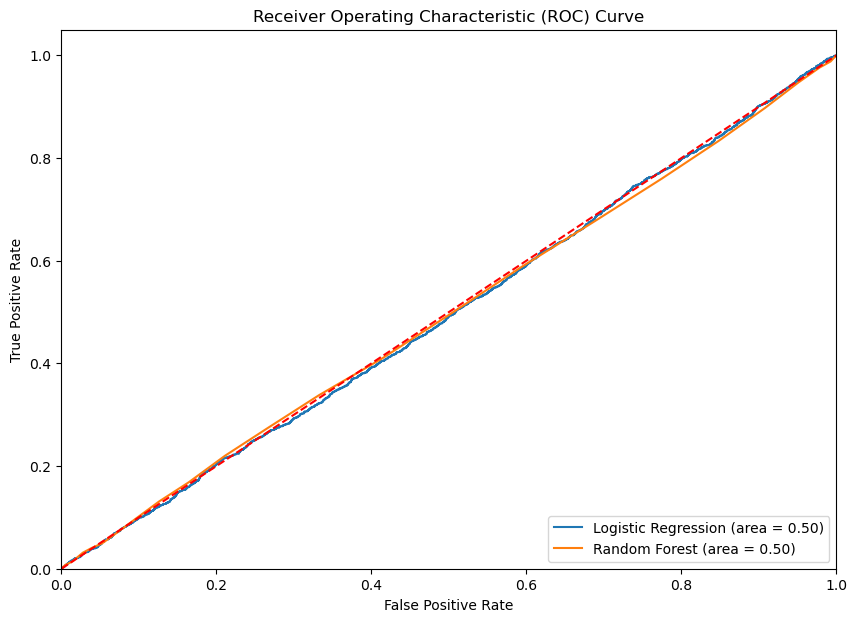

In [21]:
import matplotlib.pyplot as plt

# Calculate the ROC curve value of logistic regression
fpr_logistic, tpr_logistic, _ = metrics.roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1], pos_label='Yes')
roc_auc_logistic = metrics.auc(fpr_logistic, tpr_logistic)

# Calculate the ROC curve value of the random forest
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, random_forest_model.predict_proba(X_test)[:,1], pos_label='Yes')
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# draw the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Both logistic regression and random forest underperformed, switched to XGBoost model

In [22]:
y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert data to DMatrix format, which is the native data format of XGBoost, which can improve efficiency
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Setting parameters
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# use the training data for model training
num_round = 100
bst = xgb.train(param, dtrain, num_round)

# make predictions using test data
y_pred = bst.predict(dtest)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.82%


# Predict the Missing Values

In [35]:
missing_data = df[df['Diabetes'].isnull()]
known_data = df.dropna(subset=['Diabetes'])

In [36]:
X_known = known_data.drop(columns=['Diabetes'])
y_known = known_data['Diabetes']

In [37]:
X_missing = missing_data.drop(columns=['Diabetes'])

In [38]:
from sklearn.preprocessing import LabelEncoder

# 1. Use LabelEncoder to encode y_known
encoder = LabelEncoder()
y_known_encoded = encoder.fit_transform(y_known)

# 2. Create DMatrix with encoded labels
d_known = xgb.DMatrix(X_known, label=y_known_encoded)
d_missing = xgb.DMatrix(X_missing)

In [39]:
# Train the XGBoost model
param = {'max_depth':4, 'eta':0.3, 'objective':'binary:logistic'}
num_round = 100
bst = xgb.train(param, d_known, num_round)

# Use the XGBoost model to make predictions
y_pred_missing = bst.predict(d_missing)

# Convert probabilities to binary classification results
y_pred_missing_binary = [1 if p > 0.5 else 0 for p in y_pred_missing]

In [40]:
missing_data['Diabetes'] = y_pred_missing_binary
filled_data = pd.concat([known_data, missing_data], axis=0)

C:\Users\31332\AppData\Local\Temp\ipykernel_19576\3963029201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['Diabetes'] = y_pred_missing_binary


In [41]:
missing_values = filled_data.isnull().sum()
print(missing_values)

Student ID        1024
Age                  0
Gender               0
Height               0
Weight               0
BMI                  0
Temperature          0
Heart Rate           0
Blood Pressure       0
Cholesterol          0
Diabetes             0
Smoking              0
Blood Type_A         0
Blood Type_AB        0
Blood Type_B         0
Blood Type_O         0
dtype: int64


In [42]:
filled_data.to_csv('msd_cleaning_V2.csv', index=False)

C:\Users\31332\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
